In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models import MultipleLinear

%matplotlib inline

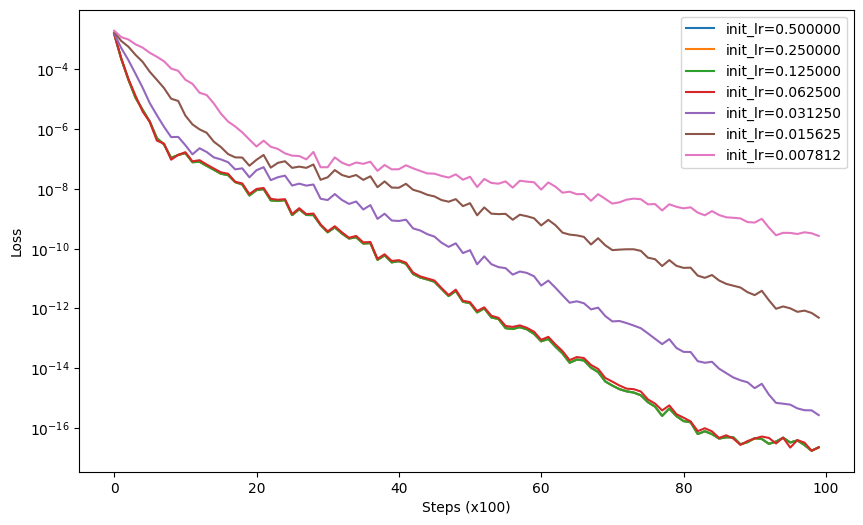

In [27]:
def run_ensemble_experiment(
    train_steps = 3000,
    meta_lr = 0.005,
    init_lr = 0.001,
    n_inputs = 1,
    n_distractors = 99,
    member_dim = 20,
    n_models = 10,
    noise_strength = 0.0,
    return_model_weights = False,
    device = torch.device('cpu'),
    seed = 20250813,
):
    torch.manual_seed(seed)
    data_generator = torch.Generator(device=device).manual_seed(seed)

    true_weights = torch.randn(1, n_inputs, device=device)
    model = MultipleLinear(member_dim + 1, 1, n_models, bias=False).to(device)
    torch.nn.init.zeros_(model.weight)

    # Sample member indices for each model, dim: (n_models, member_dim)
    # Index 0 is always the real input
    member_indices = torch.stack([
        torch.cat([
            torch.tensor([0]),
            torch.randperm(n_inputs + n_distractors - 1)[:member_dim - 1] + 1,
        ])
        for _ in range(n_models)
    ], dim=0).to(device)

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    losses = []
    model_weights = []

    for i in range(train_steps):
        true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
        noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
        
        # Get the features for each model and add bias
        features = noisy_X[member_indices]
        features = torch.cat([
            features, torch.ones(n_models, 1, device=device)], dim=1)
        
        y_preds = model(features).squeeze(1)
        target = true_weights @ true_X[:n_inputs]
        individual_losses = (target.expand(n_models) - y_preds).pow(2)
        
        with torch.no_grad():
            mean_pred = y_preds.mean()
            pred_loss = (target - mean_pred).pow(2)
            losses.append(pred_loss.item())
            if return_model_weights:
                model_weights.append(model.weight.detach().clone())

        optimizer.zero_grad()
        individual_losses.sum().backward(retain_graph=True)
        optimizer.step(predictions=y_preds)

    results = {
        'losses': losses,
        'model': model,
        'member_indices': member_indices,
        'true_weights': true_weights,
    }
    if return_model_weights:
        results['model_weights'] = torch.stack(model_weights)

    return results

init_lrs = [2**(-i) for i in range(1, 8)]
plt.figure(figsize=(10, 6))

for init_lr in init_lrs:
    results = run_ensemble_experiment(init_lr=init_lr, return_model_weights=False, n_models=20)
    plt.plot(np.array(results['losses']).reshape(100, -1).mean(1), label=f'init_lr={init_lr:.6f}')

plt.xlabel('Steps (x100)')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')


Average distance from true weight per step:
Member count 1: 0.005643
Member count 2: 0.004683
Member count 4: 0.004875
Member count 8: 0.004706
Member count 16: 0.004793
Member count 32: 0.004468
Member count 64: 0.004753


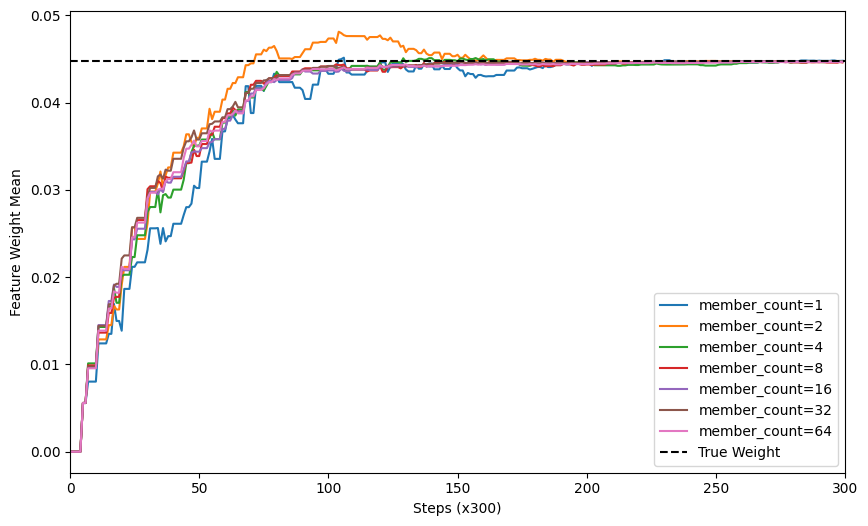

In [59]:
member_counts = [1, 2, 4, 8, 16, 32, 64]

# Store values for both plots
weight_estimates = {}
weight_differences = {}
avg_distances = {}

x_bin_size = 1
train_steps = 300

for member_count in member_counts:
    results = run_ensemble_experiment(train_steps=train_steps, init_lr=2**-4, n_models=member_count, return_model_weights=True, seed=9)
    model_weights = results['model_weights']
    real_feature_values = model_weights[:, :, 0, 0]
    real_feature_value_means = real_feature_values.mean(1)
    real_weight = results['true_weights'].item()
    
    # Store mean weights and differences from true weight
    weight_estimates[member_count] = real_feature_value_means.numpy().reshape(-1, x_bin_size).mean(1)
    weight_differences[member_count] = weight_estimates[member_count] - real_weight
    
    # Calculate average distance from true weight
    avg_distances[member_count] = np.abs(weight_differences[member_count]).mean()

# Plot weight estimates
plt.figure(figsize=(10, 6))
for member_count in member_counts:
    plt.plot(weight_estimates[member_count], label=f'member_count={member_count}')
plt.axhline(y=real_weight, color='black', linestyle='--', label='True Weight')
plt.xlabel('Steps' + f' (x{train_steps})' if train_steps > 1 else '')
plt.xlim(0, train_steps)
plt.ylabel('Feature Weight Mean')
plt.legend()

# # Plot differences from true weight
# plt.figure(figsize=(10, 6))
# for member_count in member_counts:
#     plt.plot(weight_differences[member_count], label=f'member_count={member_count}')
# plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
# plt.xlabel('Steps' + f' (x{train_steps})' if train_steps > 1 else '')
# plt.ylabel('Difference from True Weight')
# plt.legend()

# Print average distances
print("\nAverage distance from true weight per step:")
for member_count in member_counts:
    print(f"Member count {member_count}: {avg_distances[member_count]:.6f}")

-0.08391580730676651

In [33]:
real_feature_value_means

tensor([ 0.0000,  0.0000, -0.0105,  ..., -0.0839, -0.0839, -0.0839])

In [16]:
features.shape

torch.Size([10, 21])

In [ ]:
seed = 20250813
device = torch.device('cuda')

torch.manual_seed(seed)
data_generator = torch.Generator(device=device).manual_seed(seed)

n_inputs = 20
noise_strength = 0.0
n_distractors = 10000
convergence_threshold = 0.01

true_weights = torch.randn(1, n_inputs, device=device)
model = torch.nn.Linear(n_inputs + n_distractors, 1, bias=False).to(device)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.005, init_lr=0.00001, autostep=True)

# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
    noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X[:n_inputs]
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= convergence_threshold:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

Number of steps: 16001
Loss: 0.01126911186945705


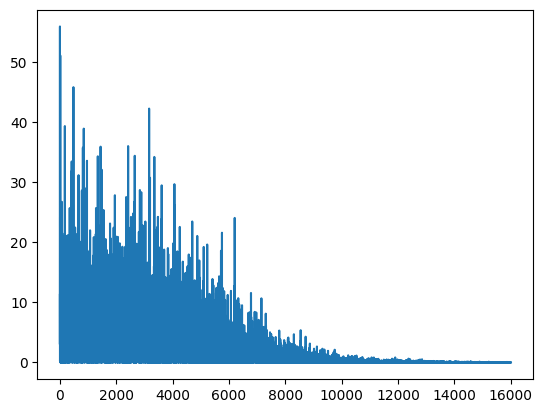

In [ ]:
seed = 20250813
device = torch.device('cuda')

torch.manual_seed(seed)
data_generator = torch.Generator(device=device).manual_seed(seed)

n_inputs = 20
noise_strength = 0.0
n_distractors = 10000
convergence_threshold = 0.01
n_models = 10

# TODO: Create a bunch of ensembles with different inputs.
# Plot the distance of the real features from their ideal weight values over time.
# Plot the L1 of the distrator weights over time, they should be closer to 0.
# Double check to make sure IDBD on multiple ensembles like this works.

true_weights = torch.randn(1, n_inputs, device=device)
model = ParallelLinear(n_inputs + n_distractors, 1, n_models, bias=False).to(device)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.005, init_lr=0.00001, autostep=True)

# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
    noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
    y_preds = model(noisy_X).squeeze(1)
    target = true_weights @ true_X[:n_inputs]
    individual_losses = (target.expand(n_models) - y_preds).pow(2)
    
    with torch.no_grad():
        mean_pred = y_preds.mean()
        pred_loss = (target - mean_pred).pow(2)
        losses.append(pred_loss.item())

    optimizer.zero_grad()
    individual_losses.sum().backward(retain_graph=True)
    optimizer.step(predictions=y_preds)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= convergence_threshold:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

In [16]:
# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs,), dtype=torch.float)
    noisy_X = true_X + torch.randn(n_inputs) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= 0:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)